In [1]:
# https://www.youtube.com/watch?v=XyX5HNuv-xE
# https://github.com/bnsreenu/python_for_microscopists/blob/master/177_semantic_segmentation_made_easy_using_segm_models.py

# https://github.com/qubvel/segmentation_models

In [2]:
import os
import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image

import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import random

Segmentation Models: using `keras` framework.


## Preprosessing

image:  (8500, 64, 64, 3)
mask:  (8500, 64, 64)
image:  (8500, 64, 64, 3)
mask:  (8500, 64, 64, 1)
unique labels in mask [0 1]


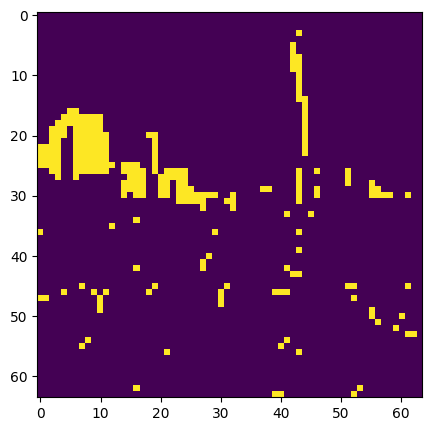

In [3]:
#these codes are used to loop through the directory
path_images = 'rs19_val/jpgs/rs19_val/'
path_mask = 'rs19_val/uint8/rs19_val/'
breaker = 0

image_dataset = []
mask_dataset = []

label_of_interest = 8 #veg
plt.figure(figsize = (10,5))

for filename in os.listdir(path_images):
    breaker +=1
    if filename.endswith('.jpg'):  
        image = Image.open(path_images+filename) 
        image = np.array(image.resize((64,64),3))
        # image = cv2.imread(path_images+filename) 
        # image = image[:1056,:,:] #divisible by 32 because of UNET requirements

        mask = Image.open(path_mask+filename[:7]+'.png') 
        mask = np.array(mask.resize((64,64),3))
        mask = np.expand_dims(mask, axis=2)
        # mask = cv2.imread(path_mask+filename[:7]+'.png')
        # mask = mask[:1056,:,:]

        # for layer in range(len(mask[0,0,:])):
            # we only care about the first layer of the mask
        # mask[:int(w/2),:,layer]=0
            # we don't need this transformation for now

        mask[:,:,0][mask[:,:,0]!=label_of_interest]=0
        mask[:,:,0][mask[:,:,0]==label_of_interest]=1
                #this is because one hot encoder can only deal with 0 and 1 if there is 2 labels

        image_dataset.append(image)
        mask_dataset.append(mask[:,:,0])
    if breaker==8500:
        break

image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
# mask_dataset = mask_dataset[:,:,:,0]
print('image: ', image_dataset.shape)
print('mask: ', mask_dataset.shape)
plt.imshow(mask[:,:,0])

mask_dataset = np.expand_dims(mask_dataset, axis=3)
print('image: ', image_dataset.shape)
print('mask: ', mask_dataset.shape)

print('unique labels in mask', np.unique(mask_dataset))

In [4]:
# split
X_train_pp, X_test_pp, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)
# pp=pre-processing -> we need to use the original for illustration


# Model

In [5]:
# Preprocessing
# https://segmentation-models.readthedocs.io/en/latest/tutorial.html#models-and-backbones
BACKBONE = 'inceptionv3'
preprocess_input = sm.get_preprocessing(BACKBONE)

X_train = preprocess_input(X_train_pp)
X_test = preprocess_input(X_test_pp)

# define the model
metrics = [sm.metrics.IOUScore(threshold=0.5), 'mse', 'accuracy']
model = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze = True, classes=1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

#print(model.summary())

In [6]:
history = model.fit(    X_train,
                        y_train,
                        batch_size=15,
                        epochs=10,
                        verbose=1,
                        validation_data=(X_test,y_test))

Epoch 1/10
454/454 [==============================] - 273s 593ms/step - loss: 0.2926 - iou_score: 0.5523 - mse: 0.0897 - accuracy: 0.8763 - val_loss: 0.2638 - val_iou_score: 0.6090 - val_mse: 0.0786 - val_accuracy: 0.8933
Epoch 2/10
454/454 [==============================] - 275s 606ms/step - loss: 0.2468 - iou_score: 0.6046 - mse: 0.0743 - accuracy: 0.8987 - val_loss: 0.2403 - val_iou_score: 0.5745 - val_mse: 0.0720 - val_accuracy: 0.9020
Epoch 3/10
454/454 [==============================] - 272s 598ms/step - loss: 0.2317 - iou_score: 0.6285 - mse: 0.0692 - accuracy: 0.9060 - val_loss: 0.2392 - val_iou_score: 0.6277 - val_mse: 0.0708 - val_accuracy: 0.9041
Epoch 4/10
454/454 [==============================] - 246s 542ms/step - loss: 0.2232 - iou_score: 0.6425 - mse: 0.0664 - accuracy: 0.9100 - val_loss: 0.2407 - val_iou_score: 0.6284 - val_mse: 0.0715 - val_accuracy: 0.9029
Epoch 5/10
454/454 [==============================] - 241s 531ms/step - loss: 0.2124 - iou_score: 0.6604 - mse: 

In [22]:
#model.save('saved_model/UNET_resnet18.hdf5')

1/1 [==============================] - 0s 37ms/step


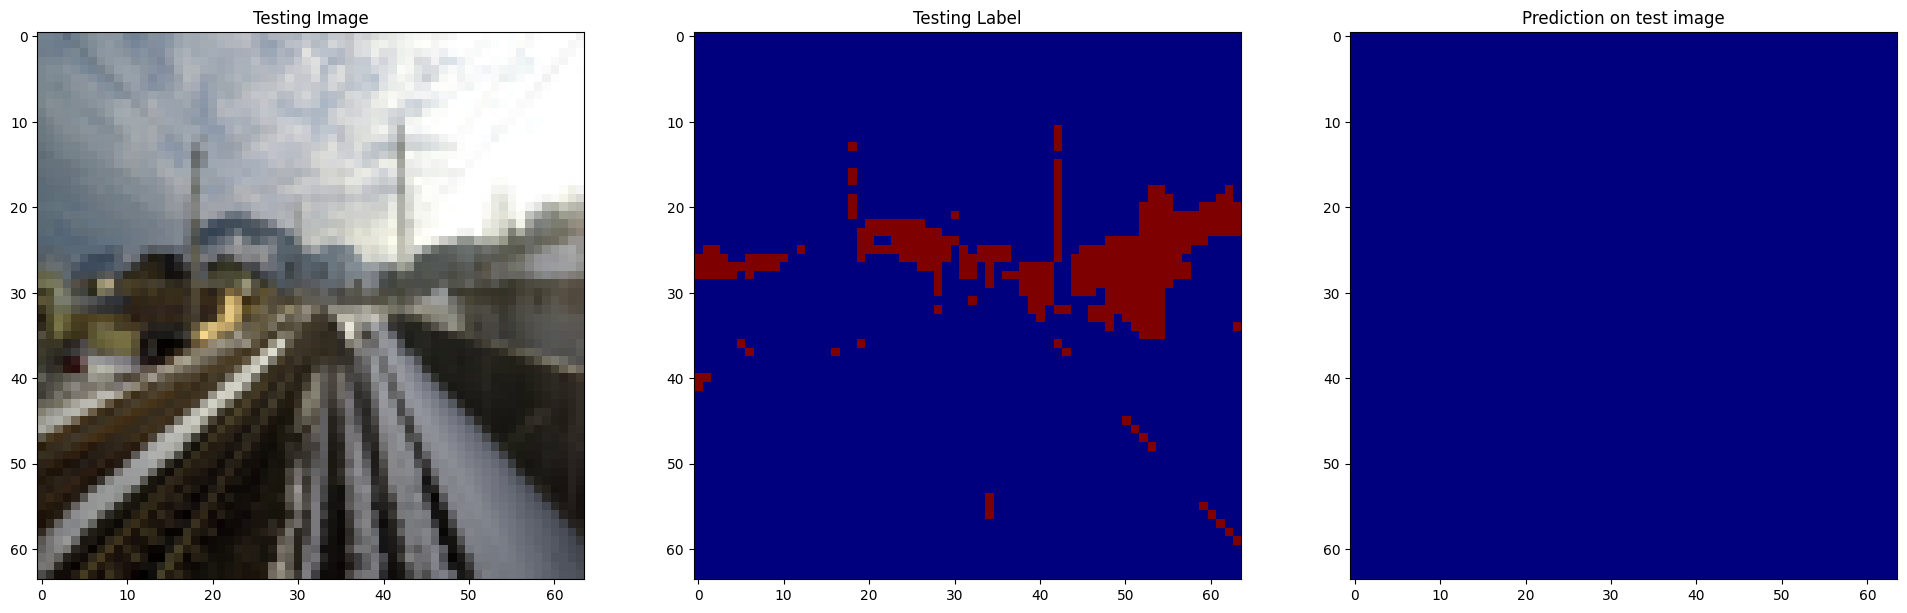

In [24]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
test_img_to_show = X_test_pp[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0) #this is to make (256, 512, 1) -> (1, 256, 512, 1)
prediction = (model.predict(test_img_input))
my_threshold = 0.99
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

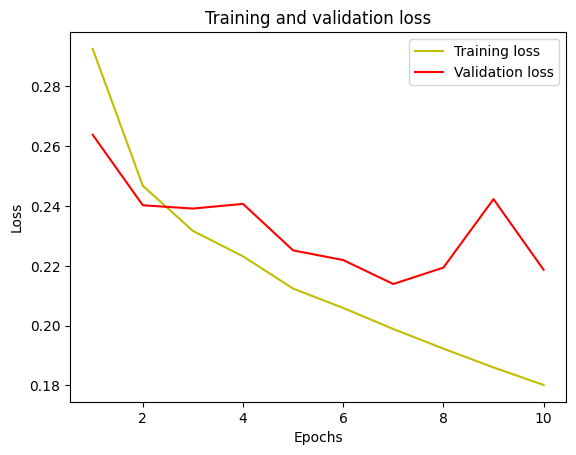

In [21]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

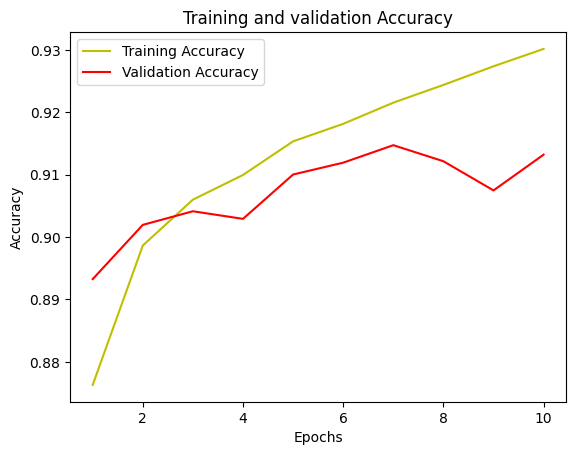

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Appendix

## EDA

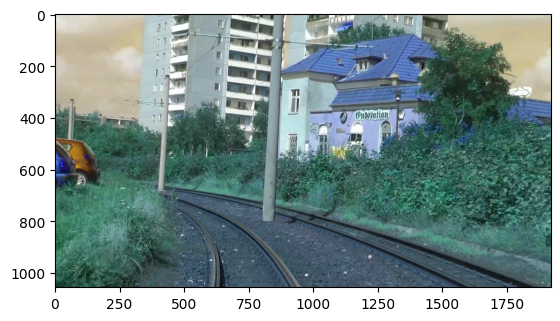

In [11]:
t_image = cv2.imread('rs19_val/jpgs/rs19_val/rs00062.jpg') 
t_image = t_image[:1056,:,:]
plt.imshow(t_image)

In [12]:
t_image = Image.open('rs19_val/uint8/rs19_val/rs00062.png') 
t_image = np.array(t_image.resize((512,256),3))
#plt.imshow(t_image)
#type(np.array(t_image))
t_image = np.expand_dims(t_image, axis=2)
print(t_image.shape)
print(np.unique(t_image))

(256, 512, 1)
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [13]:
t_image = Image.open('rs19_val/jpgs/rs19_val/rs00062.jpg') 
t_image.resize((512,256),3)
#plt.imshow(t_image)
#type(np.array(t_image))

np.array(t_image.resize((512,256),3)).shape

(256, 512, 3)

In [14]:
temp_mask = cv2.imread('rs19_val/uint8/rs19_val/rs00062.png') #3 channels but all same. 
labels, count = np.unique(temp_mask[:,:,0], return_counts=True) #Check for each channel. All chanels are identical
print("Labels are: ", labels, " and the counts are: ", count)

Labels are:  [ 2  5  8  9 10 12 13 15 17]  and the counts are:  [468923  49765 922505  10135 200993 101208  27723 224439  67909]


In [15]:
type(temp_mask)

numpy.ndarray

In [16]:
#width and length of the images
w = temp_mask.shape[0]
l = temp_mask.shape[1]

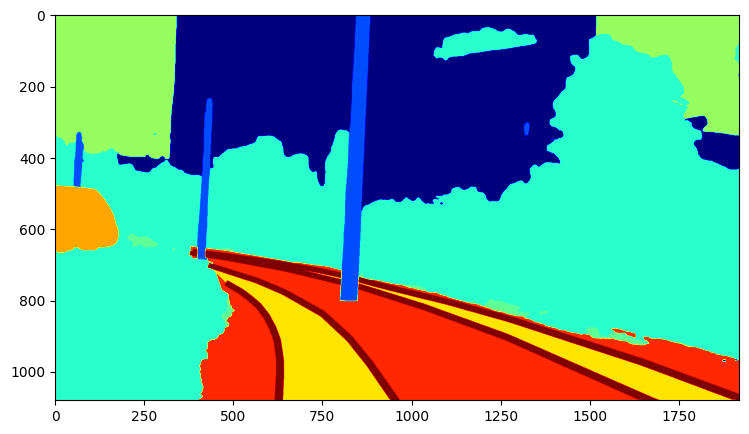

In [17]:
plt.figure(figsize = (10,5))
#before processing
plt.imshow(temp_mask[:,:,0], cmap='jet')

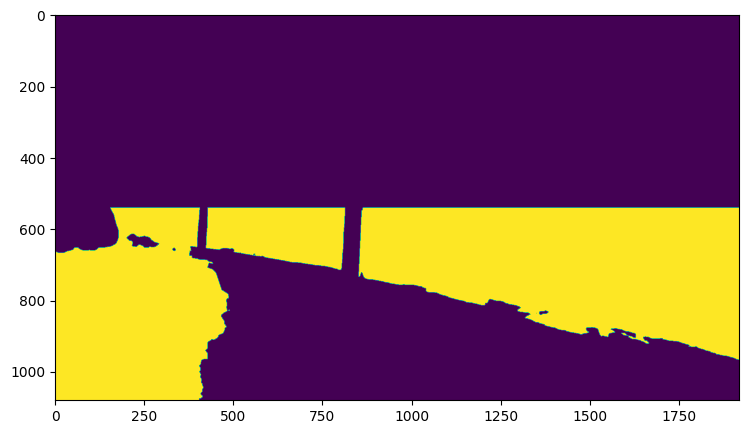

In [18]:
#temp_mask = cv2.imread('rs19_val/uint8/rs19_val/rs00062.png')
plt.figure(figsize = (10,5))
label_of_interest = 8 #veg
#after processing
temp_mask[:int(w/2),:,0]=0
temp_mask[:,:,0][temp_mask[:,:,0]!=label_of_interest]=0
plt.imshow(temp_mask[:,:,0])

In [19]:
len(np.unique(temp_mask[:,:,0]))

2